# Learning to compute a product

Unlike the communication channel and the element-wise square,
the product is a nonlinear function on multiple inputs.
This represents a difficult case for learning rules
that aim to generalize a function given many
input-output example pairs.
However, using the same type of network structure
as in the communication channel and square cases,
we can learn to compute the product of two dimensions
with the `nengo.PES` learning rule.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.processes import WhiteSignal

## Create the model

Like previous examples,
the network consists of `pre`, `post`, and `error` ensembles.
We'll use two-dimensional white noise input and attempt to learn the product
using the actual product to compute the error signal.

In [2]:
model = nengo.Network()
with model:
    # -- input and pre popluation
    inp = nengo.Node(WhiteSignal(60, high=5), size_out=2)
    pre = nengo.Ensemble(120, dimensions=2)
    nengo.Connection(inp, pre)

    # -- post population
    post = nengo.Ensemble(60, dimensions=1)

    # -- reference population, containing the actual product
    product = nengo.Ensemble(60, dimensions=1)
    nengo.Connection(
        inp, product, function=lambda x: x[0] * x[1], synapse=None)

    # -- error population
    error = nengo.Ensemble(60, dimensions=1)
    nengo.Connection(post, error)
    nengo.Connection(product, error, transform=-1)

    # -- learning connection
    conn = nengo.Connection(
        pre,
        post,
        function=lambda x: np.random.random(1),
        learning_rule_type=nengo.PES())
    nengo.Connection(error, conn.learning_rule)

    # -- inhibit error after 40 seconds
    inhib = nengo.Node(lambda t: 2.0 if t > 40.0 else 0.0)
    nengo.Connection(inhib, error.neurons, transform=[[-1]] * error.n_neurons)

    # -- probes
    product_p = nengo.Probe(product, synapse=0.01)
    pre_p = nengo.Probe(pre, synapse=0.01)
    post_p = nengo.Probe(post, synapse=0.01)
    error_p = nengo.Probe(error, synapse=0.03)

with nengo.Simulator(model) as sim:
    sim.run(60)

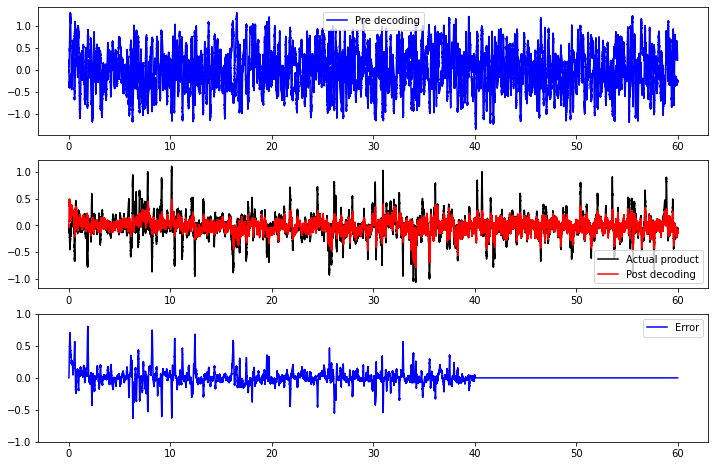

In [3]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[pre_p], c='b')
plt.legend(('Pre decoding', ), loc='best')
plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[product_p], c='k', label='Actual product')
plt.plot(sim.trange(), sim.data[post_p], c='r', label='Post decoding')
plt.legend(loc='best')
plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[error_p], c='b')
plt.ylim(-1, 1)
plt.legend(("Error", ), loc='best');

## Examine the initial output

Let's zoom in on the network at the beginning:

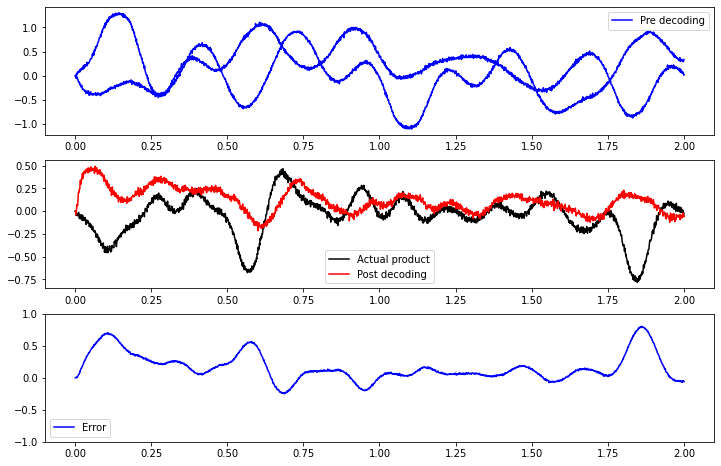

In [4]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(
    sim.trange()[:2000],
    sim.data[pre_p][:2000],
    c='b')
plt.legend(('Pre decoding', ), loc='best')
plt.subplot(3, 1, 2)
plt.plot(
    sim.trange()[:2000],
    sim.data[product_p][:2000],
    c='k',
    label='Actual product')
plt.plot(
    sim.trange()[:2000],
    sim.data[post_p][:2000],
    c='r',
    label='Post decoding')
plt.legend(loc='best')
plt.subplot(3, 1, 3)
plt.plot(
    sim.trange()[:2000],
    sim.data[error_p][:2000],
    c='b')
plt.ylim(-1, 1)
plt.legend(("Error", ), loc='best');

The above plot shows that when the network is initialized,
it is not able to compute the product.
The error is quite large.

## Examine the final output

After the network has run for a while, and learning has occurred,
the output is quite different:

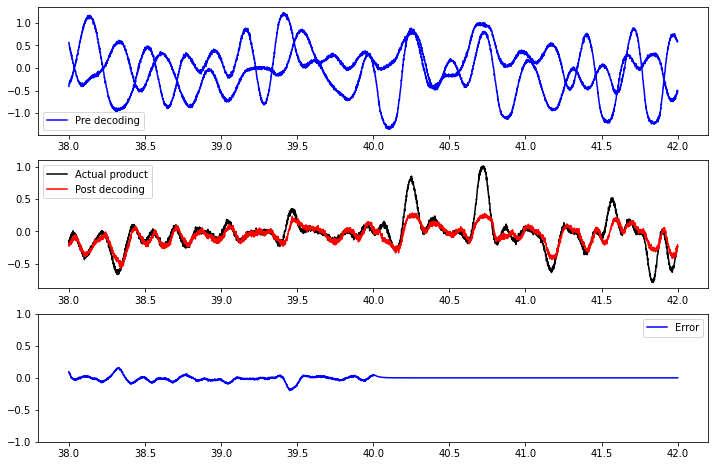

In [5]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(
    sim.trange()[38000:42000],
    sim.data[pre_p][38000:42000],
    c='b')
plt.legend(('Pre decoding', ), loc='best')
plt.subplot(3, 1, 2)
plt.plot(
    sim.trange()[38000:42000],
    sim.data[product_p][38000:42000],
    c='k',
    label='Actual product')
plt.plot(
    sim.trange()[38000:42000],
    sim.data[post_p][38000:42000],
    c='r',
    label='Post decoding')
plt.legend(loc='best')
plt.subplot(3, 1, 3)
plt.plot(
    sim.trange()[38000:42000],
    sim.data[error_p][38000:42000],
    c='b')
plt.ylim(-1, 1)
plt.legend(("Error", ), loc='best');

You can see that it has learned a decent approximation of the product,
but it's not perfect -- typically,
it's not as good as the offline optimization.
The reason for this is that we've given it white noise input,
which has a mean of 0; since this happens in both dimensions,
we'll see a lot of examples of inputs and outputs near 0.
In other words, we've oversampled a certain part of the
vector space, and overlearned decoders that do well in
that part of the space. If we want to do better in other
parts of the space, we would need to construct an input
signal that evenly samples the space.